$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Im}{\mathbf{I}}
  \newcommand{\Ym}{\mathbf{Y}}
$

# Assignment #2 - Classification

## Varsha Maurya

# Introduction

**In this assignment we are going to implement classification models like Linear discriminant analysis(LDA), Quadratic discriminant analysis(QDA), Logistic Regression and Pocket algorithm. Implementation of these algorithm will be done on classification dataset on related to Weather in Australia. We will also examine the accuracy obtained by implemented algorithms and understand difference between each algorithm. The goal of this assignment is to successfully implement pocket algorithm, discriminant analysis, and logistic regression on the dataset so as to correctly determine if a set of variables is effective in predicting category classes.**

# Data
For classification we will use the **Rain in australia** dataset and perform classification on this and try to get the result by testing the data.

### DataSet

Dataset provided in kaggle to perform classification is [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)

In [5]:
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Pre processing of the data

In [24]:
raw_data = pandas.read_csv('weatherAUS.csv',delimiter=',')

data = raw_data[['MinTemp','MaxTemp','Humidity9am','Humidity3pm','Rainfall','RainToday']]

data.isnull().sum()

data = data[pd.notnull(data['RainToday'])]

mean = data[['MinTemp','MaxTemp','Humidity9am','Humidity3pm']].mean(axis=0)

data.fillna(mean,inplace=True);

data.isnull().sum()

data.loc[:,'RainTodayC'] = data['RainToday'].replace({'No': -1, 'Yes': 1})

data.loc[:,'RainTodayC0'] = data['RainTodayC'].apply(lambda x: 1 if x ==-1 else 0)
data.loc[:,'RainTodayC1'] = data['RainTodayC'].apply(lambda x: 1 if x ==1 else 0)


Xraw = data[['Humidity3pm','Rainfall']] #this will be the input samples 
Yraw = data[['RainTodayC']] # this is the target label in this prices of the house.

print('The total number of features for the regression model are {}'.format(Xraw.shape[1]))
print('The total number of samples in this dataset are {}'.format(Xraw.shape[0]))

# we need a different Yraw for LR
Yraw_lr = data[['RainTodayC0','RainTodayC1']]


The total number of features for the regression model are 2
The total number of samples in this dataset are 140787


### Plots for Understanding and analysis

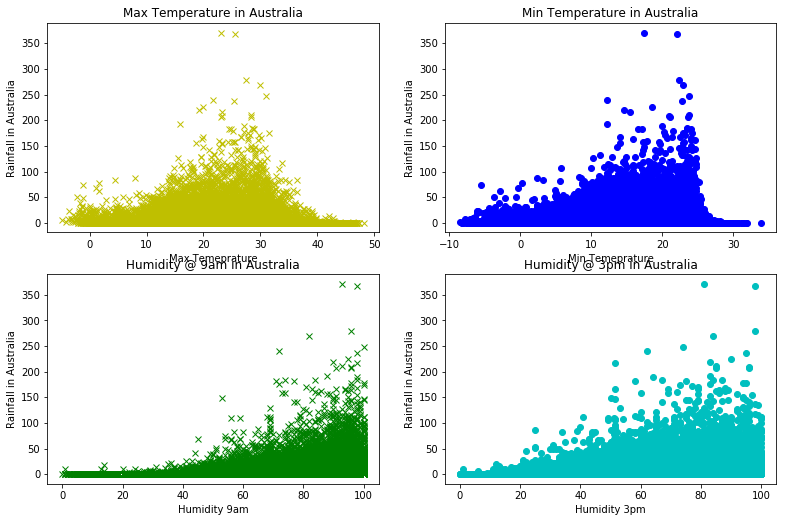

In [260]:
fig = plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(data['MaxTemp'],data['Rainfall'],'xy')
plt.title("Max Temperature in Australia")
plt.xlabel('Max Temeprature')
plt.ylabel('Rainfall in Australia')

plt.subplot(2,2,2)
plt.plot(data['MinTemp'],data['Rainfall'],'ob')
plt.title("Min Temperature in Australia")
plt.xlabel('Min Temeprature')
plt.ylabel('Rainfall in Australia')

plt.subplot(2,2,3)
plt.plot(data['Humidity9am'],data['Rainfall'],'xg')
plt.title("Humidity @ 9am in Australia")
plt.xlabel('Humidity 9am')
plt.ylabel('Rainfall in Australia')


plt.subplot(2,2,4)
plt.plot(data['Humidity3pm'],data['Rainfall'],'oc')
plt.title("Humidity @ 3pm in Australia")
plt.xlabel('Humidity 3pm')
plt.ylabel('Rainfall in Australia')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

### Prelimary Observation of the dataset

1. The Rainfall predictor is very important since that has a direct relation to the prediction of the label.
2. The Max and Min temperature  also looks to be important but Min temperature seems to be of more relavance as it has a good estimator of rain
3. Humidity at 9am and 3pm also seem to be an important parameter and Humidity at 3pm seems to be and very important feature as there is a clear relation to that of the label
4. We can also see that there is skew in the number of positive and negative labels . This is not necessarily good as this may effect the prediction and training.
5. Also the data set does not have any ordinal data that could help us improve our prediction.
6. We will be using on 2 features for the current classification.

## Helper functions


#### Partition data

In [25]:
# now partition the data 

""" partitioning data

    parameters
    -----------
    X        pd.DataFrame
             input data to partition
    T        pd.DataFrame
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    assert(np.sum(ratio) == 1)
    
    # shuffle the data indices 
    idxs = np.random.permutation(X.index)
    
    # the number of samples 
    N = X.shape[0]
    
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
        nrows = int(round(N * r))  # number of rows
        
        if k == len(ratio) -1:
            Xs.append(X.iloc[i:, :])
            Ts.append(T.iloc[i:, :])
        else:
            Xs.append(X.iloc[i:i+nrows, :])
            Ts.append(T.iloc[i:i+nrows, :])
        
        i += nrows
    
    return Xs, Ts

#### Bestfit 

In [26]:
from numpy.polynomial.polynomial import polyfit

def bestfit(X,Y):
    x = np.ravel(X[:,0])
    y = np.ravel(np.transpose(Y))
    b,m = polyfit(x,y,1)
    return x,y,b,m

#### Confusion matrix

In [27]:
# Confustion matrix 

def confusion_matrix(Y, T):
    """
        Y    ndarray
             predicted labels
        T    ndarray
             target labels
             
        @cfm DataFrame
             confusion matrix
    """
    
    if len(Y) != len(T):
        raise ValueError("Wrong prediction and target length!")
    
    classes = np.unique(T)
    n_classes = len(classes)
    
    cfm = pd.DataFrame(np.zeros((n_classes, n_classes)), index=classes, columns=classes, dtype=int)
    
    Tidx = [T == c for c in classes]
    for c in classes:
        pred_idx = Y == c
        cfm.loc[c, :] = [np.sum(np.logical_and(pred_idx, tidx)) for tidx in Tidx]
    
    return cfm

#### Estimation matrix

In [117]:
def estimation_matrix(CM):
    #precision
    precision = CM[1,1] / (CM[1,1] + CM[1,0])
    print('The precision for the current model is ',precision)
    #recall
    recall = CM[1,1] / (CM[0,1] + CM[1,1])
    print('The recall for the current model is ',recall)
    #specificity
    specificity = CM[0,0] / (CM[0,0] + CM[1,0])
    print('The specificity for the current model is ',specificity)
    #f1-score
    f1_score = 2*((precision*recall)/(precision + recall))
    print('The f1 Score for the current model is ',f1_score)


---

##### A. Super Classs Definition

In [20]:
import numpy as np
from abc import ABC, abstractmethod

# Super class for machine learning models 

class BaseModel(ABC):
    """ Super class for ITCS Machine Learning Class"""
    
    @abstractmethod
    def train(self, X, T):
        pass

    @abstractmethod
    def use(self, X):
        pass

    

class Classifier(BaseModel):
    """
        Abstract class for classification 
        
        Attributes
        ==========
        meanX       ndarray
                    mean of inputs (from standardization)
        stdX        ndarray
                    standard deviation of inputs (standardization)
    """

    def __init__(self, ):
        self.meanX = None
        self.stdX = None

    def normalize(self, X):
        """ standardize the input X """
        
        if not isinstance(X, np.ndarray):
            X = np.asanyarray(X)

        self.meanX = np.mean(X, 0)
        self.stdX = np.std(X, 0)
        Xs = (X - self.meanX) / self.stdX
        return Xs

    def _check_matrix(self, mat, name):
        if len(mat.shape) != 2:
            raise ValueError(''.join(["Wrong matrix ", name]))
        
    # add a basis
    def add_ones(self, X):
        """
            add a column basis to X input matrix
        """
        self._check_matrix(X, 'X')
        return np.hstack((np.ones((X.shape[0], 1)), X))

    ####################################################
    #### abstract funcitons ############################
    @abstractmethod
    def train(self, X, T):
        pass
    
    @abstractmethod
    def use(self, X):
        pass 

# Method 
- QDA
- LDA
- Pocket Algorithm
- Logistic Regression


## Summarize all the models and Explain the Implementation code 

**LDA and QDA**
The fundamental assumption for both LDA and QDA is that each class comes from normal distribution. However, QDA models and classifies the categorical response Y with a non-linear combination of predictor variables X whereas LDA uses a linear combination of predictor variables X.
1. Quadratic Discriminant Analysis (QDA) assumes a quadratic decision boundary and can be used to model wider range of problems. It can perform better in the presence of a limited number of training observations because it does make some assumptions about the form of the decision boundary.
2. LDA assumes that the observations within each class are drawn from a multivariate Gaussian distribution and the covariance of the predictor variables are common across all k levels of the response variable Y.
3. Quadratic discriminant analysis (QDA) provides an alternative approach. Like LDA, the QDA classifier assumes that the observations from each class of Y are drawn from a Gaussian distribution. However, unlike LDA, QDA assumes that each class has its own covariance matrix. In other words, the predictor variables are not assumed to have common variance across each of the k levels in Y. Also, LDA algorithm while training learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality.

**Logistic regression**
The logistic regression and LDA methods are closely connected and differ primarily in their fitting procedures. Logistic Regression is a binary classifier used to estimate the probability that an instance belonging to a particular class. If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). 
Logistic Regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it outputs the logistic of the result.

**Pocket algorithm**
A single perceptron is an iterative linear model that applies a step function on the linear output and the algorithm converges if and only if the training data is linearly separable. For classification, it iterates over the training examples, and update the weights in a way that would result in correct classification. Pocket algorithm is used to find final weight when Perceptron algorithm does not converge. Pocket algorithm stores weight vector which does not change for the highest number of iterations. Unlike Logistic Regression, Perceptron algorithm has no learning rate since multiplying the updated weight by any constant simply rescales the weights but never changes the sign of the prediction.



**what is the difference between LDA and QDA???**

1. The fundamental assumption for both LDA and QDA is that each class comes from normal distribution. However QDA models and classifies the categorical response Y with a non-linear combination of predictor variables X whereas LDA uses a linear combination of predictor variables X. 
2. Quadratic Discriminant Analysis (QDA) assumes a quadratic decision boundary and can be used to model wider range of problems. It can perform better in the presence of a limited number of training observations because it does make some assumptions about the form of the decision boundary.
3. LDA assumes that the observations within each class are drawn from a multivariate Gaussian distribution and the covariance of the predictor variables are common across all k levels of the response variable Y. Quadratic discriminant analysis (QDA) provides an alternative approach. Like LDA, the QDA classifier assumes that the observations from each class of Y are drawn from a Gaussian distribution. However, unlike LDA, QDA assumes that each class has its own covariance matrix. In other words, the predictor variables are not assumed to have common variance across each of the k levels in Y.
4. Also LDA algorithm while training learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality.


### Code Implementation

**pseudo-code**
$$
\delta_k(\xv) = -\frac{1}{2} \ln \vert \boldsymbol\Sigma_k \vert - \frac{1}{2} (\xv - \boldsymbol\mu_k)^\top \boldsymbol\Sigma_k^{-1} (\xv - \boldsymbol\mu_k) + \ln P(T = k). 
$$


```
QDA 
{
	train(X,T) {
		1. Find the mean of the input feature vector
		2. Find the co-variance of the input feature vector.
		3. find the prior Probabilty for the give class
	}

	use(X) {
		1. check that the train is called and we have initialized the mean,co-variance and sigma.
		2. Implement the above function .
			We find the inverese of the co-variance matrix 
			We find the natural log of the determinant of the co-variance matrix.
		3. return the discrminant
	}
	
}
```

In [65]:
class QDA(Classifier):
    def __init__(self, N):
        Classifier.__init__(self)
        self.N = N
        self.prior = None
        self.mu = None
        self.sigma = None
        
    def train(self, X, T):
        self.mu = np.mean(X, 0)
        self.sigma = np.cov(X.T)
        self.prior = len(T) / self.N
         
    def use(self, X):
        Xmu = np.array(X - self.mu)
        Cin = np.linalg.inv(self.sigma)  # Find inverse of the covariance matrix
        Cln = np.log(np.linalg.det(self.sigma))  # Find log(det(sigma))
        D = -0.5*Cln -0.5*np.sum(Xmu @ Cin * Xmu,axis=1) + np.log(self.prior)
        return D

**pseudo-code**
$$
\delta_k(\xv) = \xv^\top \boldsymbol\Sigma^{-1} \boldsymbol\mu_k -\frac{1}{2} \boldsymbol\mu_k^\top \boldsymbol\Sigma^{-1}\boldsymbol\mu_k + \ln P(T = k).
$$

```
LDA 
{
	cov(X) {
		1. We calcualte the co-variance for the enitre training sample space for all the classes.
	}

	train(X,T) {
		1. Find the mean of the input feature vector
		2. Find the prior Probabilty for the give class
	}

	use(X) {
		1. check that the train is called and we have initialized the mean,co-variance and sigma.
		2. Implement the above function .
			We find the inverese of the co-variance matrix 
		3. return the discrminant
	}
}
```

In [125]:
class LDA(Classifier):
    def __init__(self, N):
        Classifier.__init__(self)
        self.N = N
        self.prior = None
        self.mu = None
        self.sigma = None
    
    def cov(self,X):
        self.sigma = np.cov(X.T)
    
    def train(self, X, T):
        self.mu = np.mean(X, 0)
        self.prior = len(T) / N
         
    def use(self, X):
        Cin = np.linalg.inv(self.sigma)  # Find inverse of the covariance matrix
        return np.sum(X@Cin*self.mu - 0.5*self.mu@Cin * self.mu, axis=1) + np.log(self.prior)
    

**pseudo-code**
$$
\wv^{(k+1)} = \wv^{(k)} + \alpha t_i \xv_i
$$

```
Pocket Algorithm
{
	Pocket weight is use to find the pocket weight by updating the weight if 
	the current weight predicts more labels than the prebious weight.
	pocket_weight(X,T,W){
		1. find the target output using (X.w)
		2. find the sign of the above output.
		3. repeat 1 and 2 for pocketed wiehgts
		4. Compare which one is closer to the target and return that.

	}

	train(X,T) {
		1. Append ones to the input feature vector
		2. Assign zero weights intially
		3  Iterate till the number of iteration specified
			Iterate on all samples
				find y <- XxW
				if target and predict don't match yet
					update use above equation
					check pocket_weight
					if true update
			check if the weight is converged 
	}
	use(X) {
		1. Add basis
		2. Calculate the activation function 
		3. return -1 if < 0 and 1 if > 0
	}
	
}
```


In [151]:
class PocketAlgorithm(Classifier):
    def __init__(self, alpha, iteration):
        Classifier.__init__(self)
        self.w = None
    
    def pocket_weight(self,X,T,w):
        y = np.sign(X @ w)
        yp = np.sign(X @ self.w)
        #np.sum(y == T) >= np.sum(yp == T) //Ideally this should be used but the operation takes a lot of time.
        return np.sum(y) >= np.sum(yp)
        
    def train(self, X, T):
        Xa = self.add_ones(X)
        self.w = w = np.zeros(Xa.shape[1])
        for i in range(iteration):
            print('Currently at iteration ....',i)
            converged = True
            for k in range(N):
                y = w @ Xa[k]
                if np.sign(y) != np.sign(T[k]):
                    w += alpha * T[k] * Xa[k]
                    converged = False
                    if self.pocket_weight(Xa,T,w): 
                        self.w = w
            if converged:
                print("converged at ", i)
                break
        self.w = w; #This is not mandatory but to be on safer side.
        return w;
         
    def use(self, X):
        Xa = self.add_ones(X)
        activation = Xa @ self.w
        return [1 if x > 0 else -1 for x in activation]

**pseudo-code for LR**

$$
P(T=k \mid \xv) = \frac{\kappa_k}{\sum_{c=1}^K \kappa_c}
$$


$$
\wv \leftarrow \wv + \alpha \Xm^\top \Big(  \Tm - g(\Xm)\Big).
$$


LogisticRegression
{
	
	Softmax is an activation function that is used to update the predicted values
	based on if it was able to activate the function. We can either use softmax or sigmoid
	we use softmax as it is the same for 2 class predictions.
	softmax(X,W) {
		1. predict the probability of a label given the particular input feature vector
		2. We use the above equation and use exponents to make it easier to compute.
	}

	train(X,W){
		1. iterate over the total iterations
		2. apply above update rule
	}
	use(){
		1. use softmax
		2.return argmax of predicted output
	}

}

In [195]:
class LogisticRegression(Classifier):
    def __init__(self, alpha, iteration):
        Classifier.__init__(self)
        self.alpha = alpha
        self.iteration = iteration
        self.w = None
        
    def softmax(self,X,w):
        z = X @ w
        if not isinstance(z, np.ndarray):
            z = np.asarray(z)
        f = np.exp(z) 
        return f / (np.sum(f, axis=1, keepdims=True) if len(z.shape) == 2 else np.sum(f))

    def train(self, X, T):
        Xa = self.add_ones(X)
        self.w = np.zeros((Xa.shape[1],Ttrain_lr.shape[1]))
        for i in range(self.iteration):
            print('The current step iteration is ',i)
            ys = self.softmax(Xa, self.w)
            self.w += self.alpha * Xa.T @ (T - ys)
            #not added convergence yet
        return self.w
            
    def use(self, X):
        Xa = self.add_ones(X)
        Y = self.softmax(Xa,self.w)
        return np.argmax(Y, 1)

## Partition the data

In [156]:
Xlst,Tlst = partition(Xraw,Yraw)

Xlr,Tlr = partition(Xraw,Yraw_lr)

In [158]:
Xtrain, Xtest = [xx.values for xx in Xlst]
Ttrain, Ttest = [tt.values for tt in Tlst]

Xtrain_lr, Xtest_lr = [xx.values for xx in Xlr]
Ttrain_lr, Ttest_lr = [tt.values for tt in Tlr]
print('Shape of Training samples for LR is {}'.format(Ttrain_lr.shape))

print('The size of the Training dataset is {}'.format(Xtrain.shape))
print('The size of the Testing dataset is {}'.format(Xtest.shape))

Shape of Training samples for LR is (112630, 2)
The size of the Training dataset is (112630, 2)
The size of the Testing dataset is (28157, 2)


### Normalize the data

In [159]:
c = Classifier.__init__
Xs = Classifier.normalize(c,Xtrain)
means, stds = c.meanX, c.stdX
Xt = (Xtest - means) / stds


### Specifically needed for LR.. Not mandatory but since partition does a random shufffle better to have this.
Xs_lr = Classifier.normalize(c,Xtrain_lr)
means_lr, stds_lr = c.meanX, c.stdX
Xt_lr = (Xtest_lr - means_lr) / stds_lr

### Train data for QDA and LDA

In [ ]:
Xs1 = np.hstack((Xs,Ttrain))
X_c0,T_c0 = Xs[np.where(Xs1[:,-1] == -1)],Ttrain[np.where(Xs1[:,-1] == -1)]
X_c1,T_c1 = Xs[np.where(Xs1[:,-1] == 1)],Ttrain[np.where(Xs1[:,-1] == 1)]

## Implementing QDA

In [207]:
N = len(Xs)

qda = QDA(N)

qda.train(X_c0,T_c0)
d1 = qda.use(Xt)

qda.train(X_c1,T_c1)
d2 = qda.use(Xt)

In [208]:
D = np.vstack((d1,d2)).T
Yp_qda = [-1 if D[i,0] > D[i,1] else 1 for i in range(len(D))]

T_qda = Ttest.flatten()


### Visualizing QDA

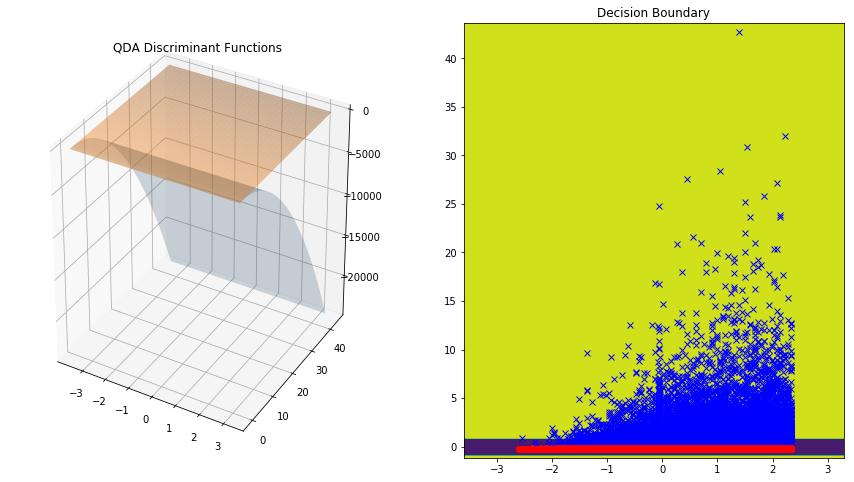

In [226]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D


# Plotting decision regions
x_min, x_max = X_c0[:, 0].min() - 1, X_c0[:, 0].max() + 1
y_min, y_max = X_c1[:, 1].min() - 1, X_c1[:, 1].max() + 1
xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Xtest1 = np.vstack((xs.flat, ys.flat)).T
XtestS = (Xtest1-means) / stds

qda.train(X_c0,T_c0)
d1 = qda.use(XtestS)

qda.train(X_c1,T_c1)
d2 = qda.use(XtestS)


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121, projection='3d')
#ax = fig.gca(projection='3d')
ax.plot_surface(xs, ys, d1.reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2.reshape(xs.shape), alpha=0.4)
plt.title("QDA Discriminant Functions")

# plt.figure(figsize=(6,6))
plt.subplot(1,2,2)
plt.contourf(xs, ys, (d2-d1 > 0).reshape(xs.shape))
plt.title("Decision Boundary")
plt.plot(X_c1[:, 0], X_c1[:, 1], 'xb')
plt.plot(X_c0[:, 0], X_c0[:, 1], 'or')




### Accuracy of QDA

In [119]:
print("Accuracy: ", 100 - np.mean(np.abs(T_qda - Yp_qda)) * 100, "%")

Accuracy:  95.52509145150407 %


### Evaluation Metrics

In [114]:
CM = confusion_matrix(Yp_qda,T_qda)
CM = CM.values

In [118]:
estimation_matrix(CM)

The precision for the current model is  0.9001901140684411
The recall for the current model is  1.0
The specificity for the current model is  0.9719688542825361
The f1 Score for the current model is  0.9474737368684342


## Implementing LDA 

In [126]:
N = len(Xs)

lda = LDA(N)

#LDA has the same co-variance matrix.
lda.cov(Xs)
lda.train(X_c0,T_c0)
d1 = lda.use(Xt)

lda.train(X_c1,T_c1)
d2 = lda.use(Xt)


In [127]:
D = np.vstack((d1,d2)).T
Yp_lda = [-1 if D[i,0] > D[i,1] else 1 for i in range(len(D))]

T_lda = Ttest.flatten()

### Visualizing the LDA

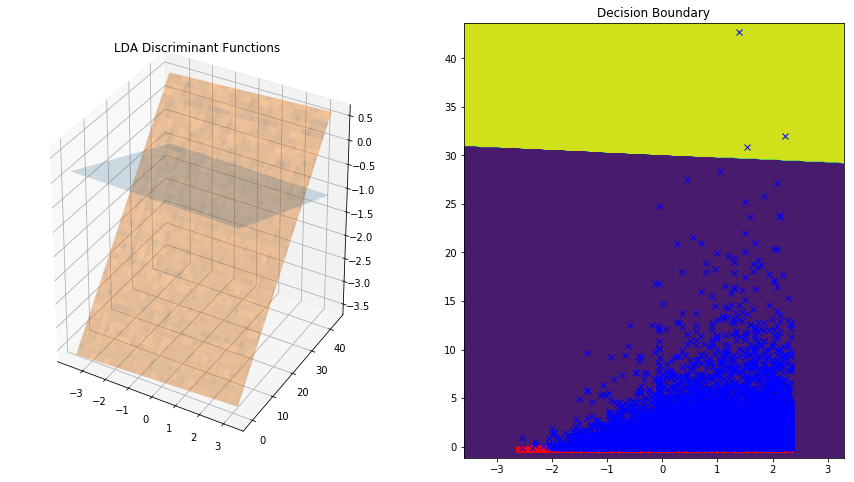

In [227]:

# Plotting decision regions
x_min, x_max = X_c0[:, 0].min() - 1, X_c0[:, 0].max() + 1
y_min, y_max = X_c1[:, 1].min() - 1, X_c1[:, 1].max() + 1
xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Xtest1 = np.vstack((xs.flat, ys.flat)).T
XtestS = (Xtest1-means) / stds

lda.train(X_c0,T_c0)
d1 = lda.use(XtestS)

lda.train(X_c1,T_c1)
d2 = lda.use(XtestS)


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121, projection='3d')
#ax = fig.gca(projection='3d')
ax.plot_surface(xs, ys, d1.reshape(xs.shape), alpha=0.2)
ax.plot_surface(xs, ys, d2.reshape(xs.shape), alpha=0.4)
plt.title("LDA Discriminant Functions")

# plt.figure(figsize=(6,6))
plt.subplot(1,2,2)
plt.contourf(xs, ys, (d2-d1 > 0).reshape(xs.shape))
plt.title("Decision Boundary")
plt.plot(X_c0[:, 0], X_c0[:, 1], 'or')
plt.plot(X_c1[:, 0], X_c1[:, 1], 'xb')

### Accuracy of LDA

In [133]:
print("Accuracy: ", 100 - np.mean(np.abs(T_lda - Yp_lda)) * 100, "%")

Accuracy:  69.72688851795291 %


### Evaluation Metrics

In [131]:
CM = confusion_matrix(Yp_lda,T_lda)
CM = CM.values

In [132]:
estimation_matrix(CM)

The precision for the current model is  1.0
The recall for the current model is  0.2499120028159099
The specificity for the current model is  1.0
The f1 Score for the current model is  0.39988735567445793


## Performing Pocket Algorithm

In [246]:
alpha = 0.1
iteration = 10 
pa = PocketAlgorithm(alpha,iteration)
W = pa.train(Xs,Ttrain)

Yp_pa = pa.use(Xt)
T_pa = Ttest.flatten()

Currently at iteration .... 0
Currently at iteration .... 1
converged at  1


### Visualizing Pocket Algorithm

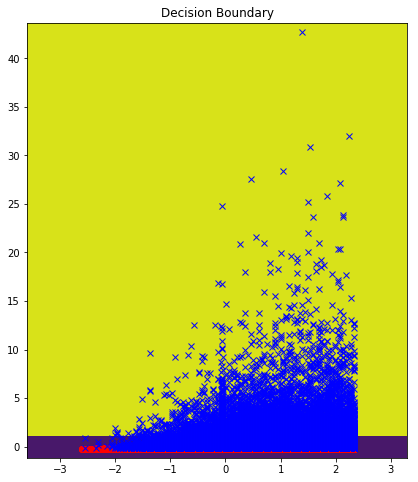

In [248]:
x_min, x_max = X_c0[:, 0].min() - 1, X_c0[:, 0].max() + 1
y_min, y_max = X_c1[:, 1].min() - 1, X_c1[:, 1].max() + 1
xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Xtest1 = np.vstack((xs.flat, ys.flat)).T
XtestS = (Xtest1-means) / stds

y1 = pa.use(XtestS)

fig = plt.figure(figsize=(15,8))
plt.subplot(1,2,2)
plt.contourf(xs, ys, np.array(y1).reshape(xs.shape))
plt.title("Decision Boundary")
plt.plot(X_c0[:, 0], X_c0[:, 1], 'or')
plt.plot(X_c1[:, 0], X_c1[:, 1], 'xb')



### Accuracy of Pocket Algorithm 

In [155]:
print("Accuracy: ", 100 - np.mean(np.abs(T_pa - Yp_pa)) * 100, "%")

Accuracy:  100.0 %


### Evaluation metrics

In [148]:
CM = confusion_matrix(Yp_pa,T_pa)
CM = CM.values

In [167]:
estimation_matrix(CM)

The precision for the current model is  1.0
The recall for the current model is  1.0
The specificity for the current model is  1.0
The f1 Score for the current model is  1.0


## Performing Logistic Regression

In [191]:
Xt_lr

array([[-1.2199251 , -0.27907052],
       [-1.02270772, -0.27907052],
       [-1.36783814, -0.27907052],
       ...,
       [-1.56505553, -0.27907052],
       [-1.41714249, -0.27907052],
       [-1.41714249, -0.27907052]])

In [202]:
alpha = 0.0001
iteration = 10
log_reg = LogisticRegression(alpha,iteration)
W = log_reg.train(Xs_lr,Ttrain_lr)

Yp_lr = log_reg.use(Xt_lr)

The current step iteration is  0
The current step iteration is  1
The current step iteration is  2
The current step iteration is  3
The current step iteration is  4
The current step iteration is  5
The current step iteration is  6
The current step iteration is  7
The current step iteration is  8
The current step iteration is  9


In [198]:
T_lr = np.argmax(Ttest_lr, 1)

array([0, 0, 0, ..., 0, 0, 0])

### Vizualizing Logistic Regression

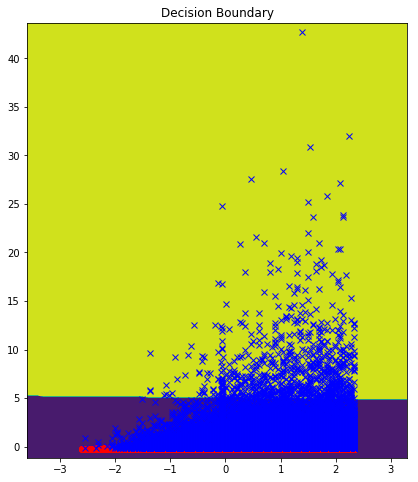

In [249]:
x_min, x_max = X_c0[:, 0].min() - 1, X_c0[:, 0].max() + 1
y_min, y_max = X_c1[:, 1].min() - 1, X_c1[:, 1].max() + 1
xs, ys = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Xtest1 = np.vstack((xs.flat, ys.flat)).T
XtestS = (Xtest1-means) / stds

y1 = log_reg.use(XtestS)

fig = plt.figure(figsize=(15,8))
plt.subplot(1,2,2)
plt.contourf(xs, ys, np.array(y1).reshape(xs.shape))
plt.title("Decision Boundary")
plt.plot(X_c0[:, 0], X_c0[:, 1], 'or')
plt.plot(X_c1[:, 0], X_c1[:, 1], 'xb')

### Accuracy off Logistic Regression

In [205]:
print("Accuracy: ", 100 - np.mean(np.abs(T_lr - Yp_lr)) * 100, "%")

Accuracy:  96.1643641012892 %


### Evaluation metric for Logistic Regression

In [203]:
CM = confusion_matrix(Yp_lr,T_lr)
CM = CM.values
print('Confusion matrix is', CM)

Confusion matrix is [[22262   867]
 [  213  4815]]


In [204]:
estimation_matrix(CM)

The precision for the current model is  0.9576372315035799
The recall for the current model is  0.8474128827877508
The specificity for the current model is  0.9905228031145717
The f1 Score for the current model is  0.8991596638655462


## Comparison of All the models




**Observation**
1. The LDA model since it uses one co-variance matrix the performance of the algorithm usually takes a hit especially if there are many samples for a particular class and very little for the other. In this case we can clearly see that is the case and thus it doesn't perform as expected.
2. The QDA seems to work reasonably well as we pass in individual class to it with it's prior, mean and variance. This allows the model to try to locate the decision boundary based on the co-variances between the class. (Intra-class) allowing to give better results.
3. For Pocket algorithm we used modified perceptron alogorithm in such a way that we updated the weights only when the prior weight that was pocket-ed was less than the current weight. This helps us in finding the weights where there was maximum matches.
4. Though this is the right approach i had to make a small modification as i have ~100k samples that needed to be checked elementwise **`sum(P(Y==T)) > sum(P(Yp==T))`** which was very expensive operation for my model so had to tweak it in such a way that i could see that the model doesn't take a lot of time.
5. For logistic regression we had to make the target to be a dimension of `N x K` so that it would be possible to carry out th operations.





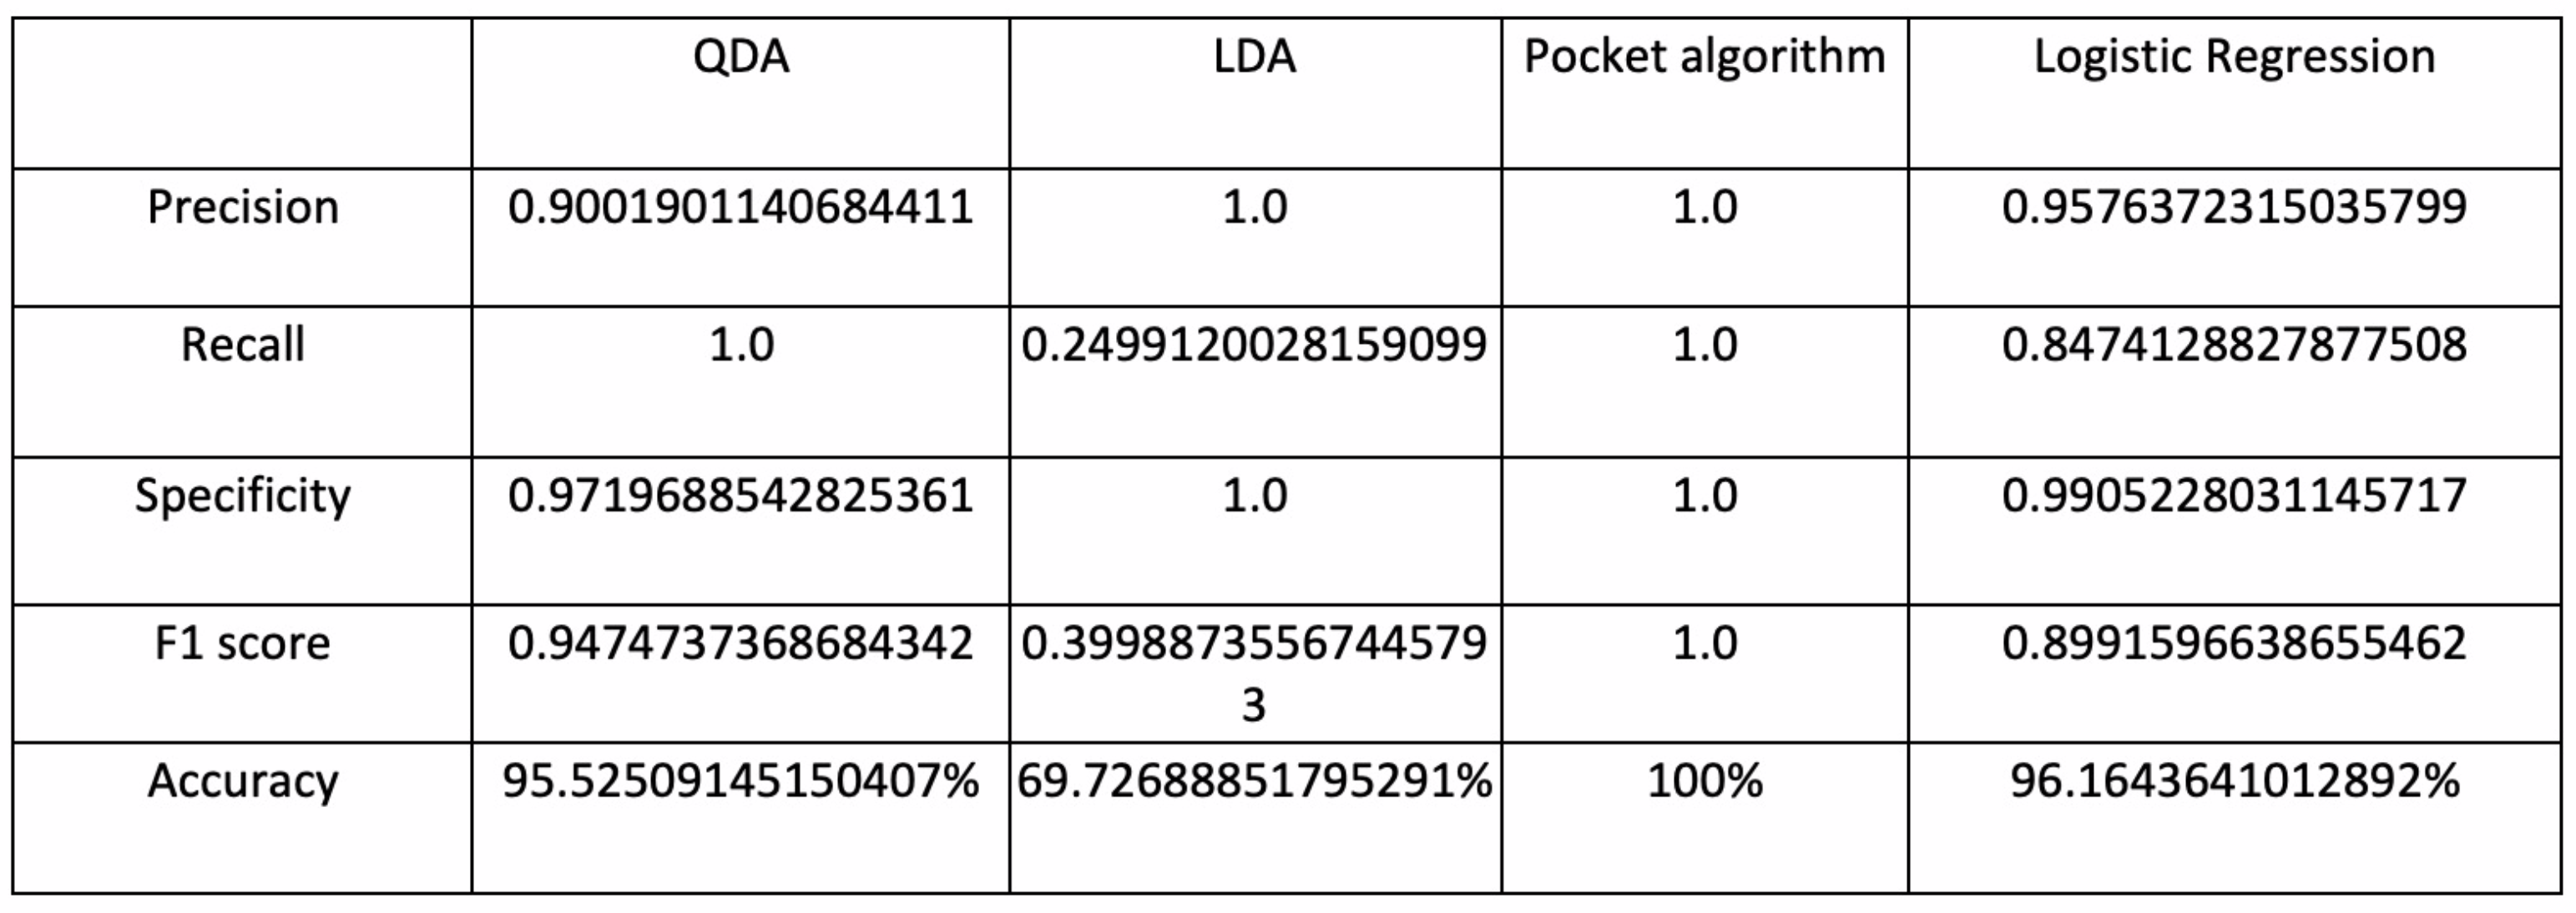

In [251]:


from IPython.display import Image
Image(filename='comparison.jpg')

# Conclusions

Summarize your work here. Which classifier do you think the best? Discuss the challenges or somethat that you learned. If you have any suggestion about the assignment, you can write about it.

1. In this assignment I learned to implement 4 classification models and was able to understand how each of the models differ from each other.
2. Learnt how gaussian distibution can be used to find the discrimanants that can be helpful in finding and predicting the labels. 
3. Learnt what is perceptron algorithm and how a small change can be made to it to improve the performance
4. Logistic regression gave me a good idea of how gradient function helps us in predicting the labels and also could learn how the equation closely resembles Linear regression function

**Challenges faced**
1. I had some problem understanding some of the equations and how that were solved in class. but asked help and got it clarified.


# References

[1]. Lachenbruch, Peter A., and M. Goldstein. "Discriminant analysis." Biometrics (1979): 69-85.

[2]. Ye, Jieping, Ravi Janardan, and Qi Li. "Two-dimensional linear discriminant analysis." Advances in neural information processing systems. 2005.

[3]. Menard, Scott. Applied logistic regression analysis. Vol. 106. Sage, 2002.

[4]. [Class Notes](https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/notes/Note-Classification.ipynb)